# Multiclass Perceptron

Environment: R 3.6.1 and Jupyter notebook

Libraries used:
* dplyr
* Matrix
* ggplot2

## Introduction

In this notebook, it is to implement a multi-class perceptron to 3 classes for classification and some visualizations against different learning rates. The algorithm as a class `Perceptron` is implemented with more generic purpose. The `Perceptron` can be trained with any batch_size, SGD or BGD, and also it can be trained to classify the binary classes data and multiple classes data.

For binary perceptron, there is one classifier to divide 2 classes. As multi-class perceptron, 3 set of weights are required to classify each class, and then in activation function to find which one is predicted highest to decide the data belong which class.

The algorithm of multi-class perceptron is shown below.
* Initialise the weight vectors randomly $w_1$,..,$w_K$
* For $n$ = 1 to N do:
    * y = argmaxk $w_k ... x_n$
    * If $y_n \ne t_n$ do
        * $w_{𝑦𝑛} \leftarrow 𝒘_{𝑦𝑛} − η𝒙_𝑛 $
        * $w_{𝑡𝑛} \leftarrow 𝒘_{𝑡𝑛} + η𝒙_𝑛 $

More details about the implementation like vectorization and algorithms will be explained in the section `Implementation`.

## Import libraries

In [1]:
options(warn=-1)

library(dplyr)
library(Matrix)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [3]:
read_data <- function(fname, sc) {
  data <- read.csv(file = fname, head = TRUE, sep = ",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  x = data[1:nr, 1:(nc - 1)]
  y = data[1:nr, nc]
  if (isTRUE(sc)) {
    x = scale(x)
    y = scale(y)
  }
  return(list("x" = x, "y" = y))
}

## Read Data

In [4]:
train_data <- read_data("train4.csv", FALSE)
x_train <- train_data$x
y_train <- train_data$y

test_data <- read_data("test4.csv", FALSE)
x_test <- test_data$x
y_test <- test_data$y

## Implement Perceptron

The implementation of `Perceptron` class is the main part of this notebook. The vectorization is widely used in the algorithm to implement a perceptron for both binary-class and multi-class classification. The multi-class perceptron can be extended by the binary-class. So, the binary-class perceptron will be introduced first. 

In the implementation, for easier programming of vectorization, the intercept value of the weights are divided as $b$ , and the rest of weights are notated as $w_n$.

### Binary-class Perceptron

Annotations:
* $w_n$: The n-th weight.
* $W$: The weight vector contains n weights, with shape $(n \times 1)$
* $b$: The intercept.
* $x_n^{(m)}$: The n-th predictor of m-th row.
* $x^{(m)}$: The predictor row vector of m-th row.
* $X$: The predictor matrix with shape $(m \times n)$
* $y^{(m)}$: The m-th row prediction.
* $Y$: The column vector of predictions with shape $(m \times 1)$.
* $f$: The activation function for transform the positive result as $1$ and negative as $-1$ .

For binary classification, the weight $w_n$ and intercept $b$ are used to computing the predicted value of $x_n^{(m)}$ as,
$$\begin{align}
y^{(m)} &= f\left(\sum_{i=1}^{n}{w_i x_i^{(m)}} + b\right) \\
&= f\left(w_1 x_1^{(m)} + w_2 x_2^{(m)} + \dots + w_n x_n^{(m)} + b\right)
\end{align}$$

So, the computation for predicting m-th row label can be vectorized as below,
$$\begin{align}
y^{(m)} &= f\left(\bigl(\begin{matrix} x_1^{(m)} & x_2^{(m)} & \cdots & x_n^{(m)} \end{matrix}\bigr) \cdot
\begin{pmatrix} w_1\\ w_2\\ \vdots\\ w_n \end{pmatrix} + b\right) \\
&= f\left(x^{(m)} \cdot W + b\right)
\end{align}$$

The vectorization below can reduce one for-loop, and use just one matrix multiplication to calculate the $y^{(m)}$ for one row. And next, the calculation of multiple rows can be vectorized as well. The $y$ for each row can be stack as a column vector $Y$ with shape $m \times 1$.

$$\begin{align}
Y = \begin{pmatrix} y^{(1)}\\ y^{(2)}\\ \vdots\\ y^{(m)} \\ \end{pmatrix} 
 &= f\left(\begin{pmatrix} x_1^{(1)} & x_2^{(1)} & \cdots & x_n^{(1)}\\ x_1^{(2)} & x_2^{(2)} & \cdots & x_n^{(2)}\\ 
\vdots & \vdots & \ddots & \vdots\\  x_1^{(m)} & x_2^{(m)} & \cdots & x_n^{(m)} \end{pmatrix} \begin{pmatrix} w_1\\ w_2\\ \vdots\\ w_n \end{pmatrix} + 
\begin{pmatrix} b\\ b\\ \vdots\\ b \end{pmatrix} \right) \\
 &= f\left(X \cdot W + b\right)
\end{align}$$


With further vectorization, only one matrix multiplication is needed to calculate all y-value for whole dataset. In R language, the vectorized computation is far more faster than for-loop. As the vectroziation is linearly, the gradient of W is also easy to calculate. With learning rate $\eta$. From the pdf, the gradient descent can be applied as,

$$\begin{equation}
\left\{\begin{array}{} 
W &\leftarrow W + \eta \cdot X^T Y \mbox{,}  \\
b &\leftarrow b + \eta \cdot Y 
\end{array}\right.\\
\mbox{The X and Y only contains the misclassified rows}
\end{equation}$$

### Multi-class Perceptron

Annotation:
* $w_{nk}$: The n-th weight for k-th classifier
* $w_{k}$: The weights vector for k-th classifier with shape $(1 \times k)$
* $W$: The weights matrix contains k classifiers with each having n weights, with shape $(n \times k)$
* $b_k$: The intercept for k-th classifier.
* $B$: The intercepts vector containing k intercepts with shape $(1 \times k)$.
* $x_n^{(m)}$: The n-th predictor of m-th row.
* $x^{(m)}$: The predictor row vector of m-th row with shape $(1 \times n)$.
* $X$: The predictor matrix with shape $(m \times n)$
* $y_k^{(m)}$: The m-th row y-value prediction for k-th class.
* $y^{(m)}$: The y-value row vector for the m-th row shape $(1 \times k)$.
* $Y$: The matrix of y-value with shape $(m \times k)$.
* $f$: The activation function for transform the vector result to find the maximum to get the label.

For the number of class is larger than 3, multiple binary-class classifiers with weights are needed. As the linear algebra has favorable generalization for linear computations. The similar method of vectorization can be applied for multi-class perceptron as well.

The main different of multi-class perceptron from binary-class is the multiple weights vector is needed. Therefore, they can be vectorized by stacking as a matrix with shape $(n \times k)$ like below,

$$\begin{align}
W = \left(\begin{matrix} w_1 & w_2 & \cdots & w_k \end{matrix}\right) = \begin{pmatrix}
w_{11} & w_{21} & \cdots & w_{k1}\\ 
w_{21} & w_{22} & \cdots & w_{k2}\\ 
\vdots & \vdots & \ddots & \vdots\\ 
w_{m1} & w_{2m} & \cdots & w_{kn}
\end{pmatrix}
\end{align}$$

Then, the similar method can be applied in prediction the y-value. Also, as there are k classifiers, there is a y vector formed by k y-values.

$$\begin{align} 
Y = \begin{pmatrix} y^{(1)}\\ y^{(2)}\\ \vdots\\ y^{(m)} \\ \end{pmatrix} = \begin{pmatrix} 
y_1^{(1)} & y_2^{(1)} & \cdots & y_k^{(1)}\\ y_1^{(2)} & y_2^{(2)} & \cdots & y_k^{(2)}\\ 
\vdots & \vdots & \ddots & \vdots\\ y_1^{(m)} & y_2^{(m)} & \cdots & y_k^{(n)}
\end{pmatrix}
\end{align}$$

Also, the $B$ vector combined the k intercepts for each classifier, so
$$
B = \left(\begin{matrix} b_1 & b_2 & \cdots & b_k \end{matrix}\right)
$$

From the equations got in binary-class perceptron, the $Y$ can be calculated from $X$, $W$ and $B$ as,

$$
Y = f(XW + B)
$$

Also,

$$w_{𝑦𝑛} \leftarrow 𝒘_{𝑦𝑛} − η𝒙_𝑛 $$
$$w_{𝑡𝑛} \leftarrow 𝒘_{𝑡𝑛} + η𝒙_𝑛 $$

Besides, the gradient of $W$ and $B$ for error function can be,
$$\begin{align}
&\nabla{E(W)} = -X^{T}Y \\
&\nabla{E(B)} = -Y
\end{align}$$

Therefore, the matrix$Y$ can be considered a mask, which is implemented to combined the formulas. When the the prediction is true, the mask is 1, else -1. This mask can perform the difference of the add/minus in the above training process. Therefore, the it can be considered as 
$$W \leftarrow W - \eta \nabla{E(W)}$$
$$B \leftarrow B - \eta \nabla{E(B)}$$


### Perceptron class

From the formula $Y = f(XW + B)$, the class `Perceptron` can be implemented as the similar format with `KNNRegressor` in `knn_regressor.ipynb`. There are many fields and methods in the class. The functionality of them are shown below.

* fields:
    * `w`: The coefficients matrix $W$ of $X$, which has been mentioned above.
    * `b`: The intercept vector $B$ of the model.
    * `history`: A dataframe to store the trends of weights and errors.
    
* methods:
    * `fit`: Train the model by given training dataset.
    * `predict`: A method to predict label $y$ from given dataset $X$ .
    * `preprocess`: A method for intializing parameters, shuffle data and split as batches.
    * `step_activation`: The activation function can transfer float(double) as 1 or -1 by its potitive and negative.
    * `max_activation`: The activation function for predict the label by the results of classifiers (reversed one hot).
    * `loss`: A function for calculate the error.
    * `get_history_names`: A function for generate column names of history data frame
    * `to_batches`: A function for split data as batches
    
For more details of definition of this class, please refer to the codes below and their comments.

In [5]:
Perceptron <- setRefClass("Perceptron", fields = list(w = "Matrix", b = "numeric", history = "data.frame"), 
                          methods = list(
    fit = function(x, y, epochs, batch_size = 1, validation_data = NULL, learning_rate_decay = 1,
                   learning_rate = 0.01, shuffle = TRUE, history_per_step = FALSE) {
      # divide the data as batches
      batches <- .self$preprocess(x, y, batch_size, shuffle)

      fit_each_epoch <- function(epoch) {
        fit_each_batch <- function(batch) {
          # reformat the x y dataframe as matrix for computation
          if (batch_size == 1) {
            x_batch <- t(Matrix(batch$x))
            y_batch <- t(Matrix(batch$y))
          } else {
            x_batch <- Matrix(batch$x)
            y_batch <- Matrix(batch$y)
          }
          # predict the data is belonged to which class
          y_hat <- .self$predict(x_batch, .self$max_activation)
          # inverse one hot to find real labels
          y_target <- .self$max_activation(y_batch)
          # locate the misclassified index
          misclassified_index <- (y_hat != y_target) %>% as.vector
          # define a mask for calculating the gradient  
          y_mask <- y_batch - .self$predict(x_batch, .self$step_activation)
          # training, if all the prediction match, skip.
          if (sum(misclassified_index) != 0) {
            # vectorized calculation of the gradient by grad(w) = xy, and grad(b) = y
            grad_w <- (-1 * t(x_batch) %*% y_mask) / batch_size
            grad_b <- -1 * colMeans(y_mask %>% Matrix) * batch_size / sum(misclassified_index)

            # apply the gradient descent
            .self$w <- .self$w - learning_rate * grad_w
            .self$b <- .self$b - learning_rate * grad_b
          }

          # generate history data for weights and error of given test data
          if (is.null(validation_data)) c(.self$b, as.vector(.self$w))
          else {
            x_test <- validation_data[[1]]
            y_test <- validation_data[[2]]
            test_error <- .self$loss(x_test, y_test)
            # stack the b and w, as the weights history for output
            weights <- rbind(.self$b, .self$w)
            # flatten the matrix as a vector and concat the test_error for output
            c(as.vector(weights), test_error)
          }
        }
        # if the learning_rate_decay is set,
        # here it can apply learning rate decay.
        if (learning_rate_decay != 1) {
          learning_rate <<- learning_rate * learning_rate_decay
        }
        # apply the function above and return the history of this epoch
        batch_history <- lapply(batches, fit_each_batch)
        # output the history by each epoch or by each step(mini-batch)
        if (history_per_step) batch_history
        else batch_history[[length(batch_history)]]
      }
      # reformat the history data frame
      if (history_per_step) {
        # get history from training on each epoch, and combine as a data frame
        weight_history <- 1:epochs %>% lapply(fit_each_epoch) %>%
          unlist(recursive = FALSE) %>% Reduce(f = rbind) %>% as.data.frame
        # generate column names and set
        col_names <- c("step", .self$get_history_names(x, y, validation_data))
        # add step/epoch and colnames for the history data
        .self$history <- cbind(1:nrow(weight_history), weight_history) %>% `colnames<-`(col_names)
        .self
      } else {
        # reformat the history data if only logged on epoch
        weight_history <- as.data.frame(t(sapply(1:epochs, fit_each_epoch)))
        col_names <- c("epoch", .self$get_history_names(x, y, validation_data))
        .self$history <- cbind(1:epochs, weight_history) %>% `colnames<-`(col_names)
        .self
      }
    },

    predict = function(x, activation) {
      if (class(x) == "data.frame") x <- x %>% data.matrix %>% Matrix
      else if (class(x) == "numeric") x <- x %>% Matrix %>% t
      # broadcast b
      b <- .self$b %>%
        rep(times = nrow(x)) %>%
        Matrix(nrow = nrow(x), byrow = TRUE)
      # predict the Z as XW+B by vectorization computation
      z <- x %*% .self$w + b
      # calculate Y_hat = f(Z)  
      activation(z)
    },

    preprocess = function(x, y, batch_size, shuffle = TRUE) {
      # this function is for preprocessing the data frame input
      x_len <- nrow(x)
      if (!class(y) %in% c("data.frame", "matrix", "Matrix")) y <- Matrix(y)
      n_classes <- ncol(y)
      # if fit in the first time, initialize the weights
      if (.self$w %>% length == 0) {
        .self$w <- Matrix(runif(ncol(x) * n_classes), ncol = n_classes)
        .self$b <- runif(n_classes)
      }
      # if shuffle applied, shuffle the data
      if (shuffle) {
        index <- sample(1:x_len, x_len, replace = FALSE)
        x <- x[index,]
        y <- y[index,]
      }
      # divide the data
      batches <- .self$to_batches(x, y, batch_size)
      batches
    },

    step_activation = function(z) {
      # this activation function input float(double) numbers, and return -1 or 1
      activation_f <- function(each_z) {
        if (each_z >= 0) 1
        else -1 }
      apply(z, 2, function(row) sapply(row, activation_f))
    },

    max_activation = function(z) {
      # this activation function return the prediction of class with maximum value
      if (ncol(Matrix(z)) != 1) apply(z, 1, which.max)
      # if the model is for binary classification, use the step_activation for the output
      else .self$step_activation(z)
    },

    loss = function(x, y) {
      # this function is for computing the loss with the x y data given
      y_hat <- .self$predict(x, activation = .self$max_activation)
      y_true <- {
        if (ncol(Matrix(y)) != 1) .self$max_activation(y)
        else y
      }
      misclassified_index <- y_true != y_hat
      sum(misclassified_index) / nrow(x)
    },

    get_history_names = function(x, y, validation_data = NULL) {
      # this function for generate the column names of history data
      classes_n <- ncol(Matrix(y))
      # generate weight column names
      col_names <- {
        if (classes_n == 1) {
          w_names <- sapply(1:ncol(x), function(i) paste0("w", i))
          c("b", w_names)
        } else {
          comb_names <- NULL
          for (class_n in 1:classes_n) {
            w_names <- sapply(1:ncol(x), function(i) paste0("c", class_n, "w", i))
            comb_names <- c(comb_names, paste0("c", class_n, "b"), w_names)
          }
          comb_names
        }
      }
      # generate test_error column names if needed
      if (is.null(validation_data)) col_names
      else c(col_names, "test_error")
    },

    to_batches = function(x, y, batch_size) {
      # this function is for divide the data as batches
      # as the batches are not divided equally, so there are complete batches,
      # and a residual batch.
      x <- as.matrix(x)
      y <- as.matrix(y)
      x_nrow <- nrow(x)
      # the number of complete batches
      complete_batch_num <- floor(x_nrow / batch_size)
      # The last row of complete batches
      complete_nrow <- complete_batch_num * batch_size
      # locate the residual part
      if (complete_nrow == x_nrow) {
        x_residual <- NULL
        y_residual <- NULL
        batch_nums <- complete_batch_num
      } else {
        x_residual <- x[(complete_nrow + 1):x_nrow,]
        y_residual <- y[(complete_nrow + 1):x_nrow,]
        batch_nums <- complete_batch_num + 1
      }
      # get residual batch data
      residual_nrow <- x_nrow - complete_nrow
      if (residual_nrow == 1) {
        x_residual <- t(x_residual)
        y_residual <- t(y_residual)
      }
      # locate and get other batches
      lapply(1:batch_nums, function(i) {
        start_index <- (i - 1) * batch_size + 1
        if (start_index + batch_size - 1 <= x_nrow) {
          list(x = x[start_index:(start_index + batch_size - 1),],
               y = y[start_index:(start_index + batch_size - 1),])
        } else {
          list(x = x_residual, y = y_residual)
        }
      })
    }
  )
)

#### Preprocess the labels

As the labels are factors `C1`, `C2` and `C3`, the labels need to be one hot encoded to a vector which indecates the related label is $1$ and others are $-1$. For example, the $y$ = `C2` label will be encoded as $y = \left(\begin{matrix} -1 & 1 & -1 \end{matrix}\right)$.

In [6]:
perceptron_one_hot <- function(y, classes = unique(y)) {
  1:length(classes) %>% 
    lapply(FUN = function(i) ifelse(y == classes[i], 1, -1) %>% matrix) %>%
    Reduce(f = cbind)
}

y_test_onehot <- perceptron_one_hot(y_test)
y_train_onehot <- perceptron_one_hot(y_train)

#### Train the perceptrons

The 2 models trained below are all same except the learning rate. One is 0.01 and another is 0.09.

In [7]:
# Time comsumption: about 50 seconds
set.seed(5201)
# train 2 models, with 220 epochs, 5 batch-size, 0.97 learning rate decay and shuffle the data.
# the learning rate are 0.01 and 0.09.
perceptron1 <- Perceptron()$fit(x_train, y_train_onehot, epoch = 160, batch_size = 5, learning_rate_decay = 0.97,
                               validation_data = list(x_test, y_test_onehot),
                               learning_rate = 0.01, shuffle = TRUE, history_per_step = TRUE)

perceptron2 <- Perceptron()$fit(x_train, y_train_onehot, epoch = 160, batch_size = 5, learning_rate_decay = 0.97,
                               validation_data = list(x_test, y_test_onehot),
                               learning_rate = 0.09, shuffle = TRUE, history_per_step = TRUE)

## Visualization

In the visualization section, the plot needed to be visualized is the trend plot of test error against mini-batches, which is counted as step in the `Perceptron` implementation.

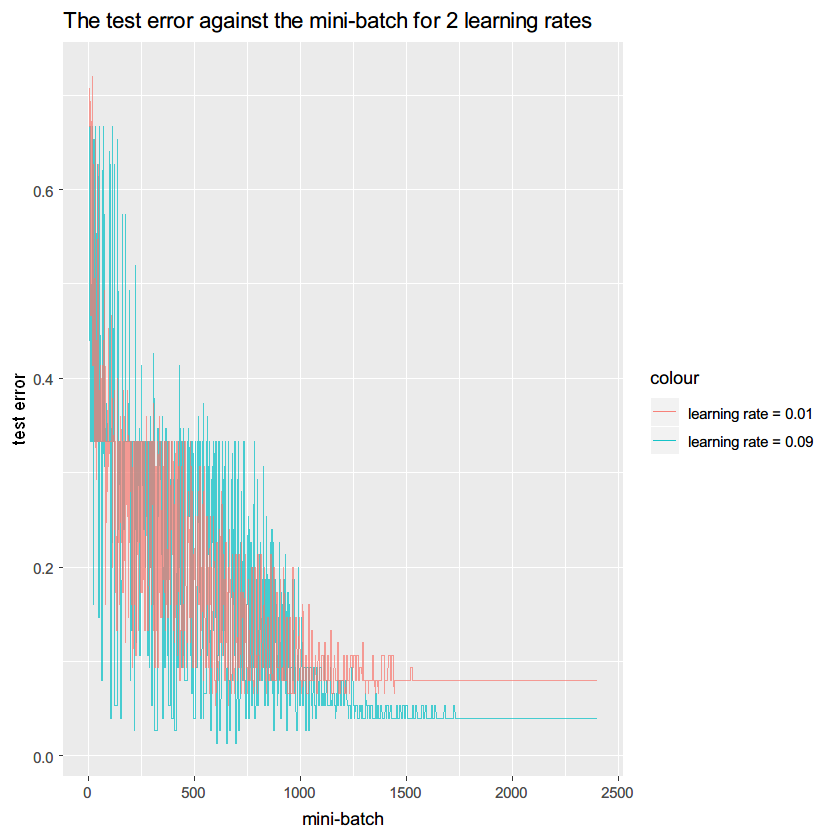

In [8]:
# reformat the data frame for plot
error_df <- cbind(perceptron1$history$step, perceptron1$history$test_error, perceptron2$history$test_error) %>%
  as.data.frame %>% `colnames<-`(c("step", "model1", "model2"))

# plot
ggplot(error_df) + 
    geom_line(mapping = aes(x = step, y = model2, color = "learning rate = 0.09"), alpha = 0.7) +
    geom_line(mapping = aes(x = step, y = model1, color = "learning rate = 0.01"), alpha = 0.7) +
    ggtitle("The test error against the mini-batch for 2 learning rates") +
    xlab("mini-batch") + ylab("test error")

Explain:

The training with learning rate = 0.09 has more significant fluctuation than learning rate = 0.01. It is because the training process with larger learning rate causes overshooting easier. So, when the learning rate is 0.09, the training process is not stable compared with the model with learning rate = 0.01 .

With the learning rate decay, the model training process can train the weights with decreasing learning rate which is beneficial for the overshotting problem. As for the speed of training, the number of mini-batches of training model of learning rate = 0.1 to stable situation is fewer than the model with learning rate = 0.09, which means the learning rate = 0.1 is faster than learning rate = 0.9 .

In the end of the models training, both of them are keeping stable, but the test errors are not at 0. It is because the training error has been 0, so there is no gradient to train the weights, leading to a stable situation in the end of training. The distribution of train and test data is not totally same, so it not means the best model for training data is also the best for test data.
